In [1]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as scs
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [4]:
from IPython.core.display import display, HTML
def jupyter_interactive_mode():
    display(HTML(
    '<style>'
    '#notebook { padding-top:0px !important; }'
    '.container { width:100% !important; }'
    '.end_space { min-height:0px !important}'
    '</style'
    ))

In [5]:
import warnings
warnings.filterwarnings('ignore')
jupyter_interactive_mode()

In [6]:
pwd

'/Users/adheerchauhan/Documents/Tutorials'

In [4]:
# from backtester.dataSource.yahoo_data_source import YahooStockDataSource
# start_date = '2016/12/31'
# end_date = '2021/09/30'
# cached_folder = '/Users/adheerchauhan/Documents/Tutorials/yahooData/'
# dataSetId = 'TimeSeriesModeling'
# instrumentIds = ['ETH-USD']
# ds = YahooStockDataSource(cachedFolderName=cached_folder,
#                          dataSetId=dataSetId,
#                          instrumentIds=instrumentIds,
#                          startDateStr=start_date,
#                          endDateStr=end_date,
#                          event='history')

In [5]:
# print("List of available Features: %s"%ds.getBookDataFeatures())
# data_dict = ds.getBookDataByFeature()

In [7]:
import yfinance as yf

def load_financial_data(start_date, end_date, ticker='ETH-USD'):
    output_file=f'{ticker}-pickle-{start_date}-{end_date}'
    try:
        df = pd.read_pickle(output_file)
        print(f'File data found...reading {ticker} data')
    except FileNotFoundError:
        print(f'File not found...downloading the {ticker} data')
        df = yf.download(ticker, start=start_date, end=end_date)
        df.to_pickle(output_file)
    return df

In [41]:
start_date = pd.datetime(2016, 1, 1)
end_date = pd.datetime(2022, 4, 13)
data = load_financial_data(start_date, end_date)
data.columns = ['open', 'high', 'low', 'close', 'adjClose', 'volume']

File data found...reading ETH-USD data


In [42]:
data.head()

,open,high,low,close,adjClose,volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [43]:
# data = pd.concat(data_dict, axis=1)
# data = data.droplevel(1, axis=1)
data = data.assign(pct_returns = data['adjClose'].pct_change())
data = data.assign(log_returns = np.log(data.adjClose/data.adjClose.shift(1))).dropna()

In [44]:
data.tail()

,open,high,low,close,adjClose,volume,pct_returns,log_returns
Date,,,,,,,,
2022-04-09,3191.976074,3261.963135,3187.469238,3261.916260,3261.916260,9908112156,0.021880,0.021644
2022-04-10,3261.291504,3303.003174,3211.866943,3211.866943,3211.866943,10427054790,-0.015344,-0.015462
2022-04-11,3209.576904,3214.461914,2962.756592,2981.052246,2981.052246,21891804831,-0.071863,-0.074576
2022-04-12,2981.420654,3077.452637,2957.872314,3030.376465,3030.376465,20235707410,0.016546,0.016411
2022-04-13,3029.877930,3123.575439,3006.481689,3118.344238,3118.344238,16088473629,0.029029,0.028615


In [45]:
# Augmented Dickey Fuller Test for adjClose Prices
adfuller_test = adfuller(data['adjClose'])
print('ADF Statistic: %f'%adfuller_test[0])
print('p-value: %f'%adfuller_test[1])
print('Critical Values:')
for key, value in adfuller_test[4].items():
    print('\t%s: %.3f'%(key,value))

ADF Statistic: -0.563456
p-value: 0.879028
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [46]:
# Augmented Dickey Fuller Test for Log Returns
adfuller_test = adfuller(data['pct_returns'])
print('ADF Statistic: %f'%adfuller_test[0])
print('p-value: %f'%adfuller_test[1])
print('Critical Values:')
for key, value in adfuller_test[4].items():
    print('\t%s: %.3f'%(key,value))

ADF Statistic: -11.899586
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [47]:
# Augmented Dickey Fuller Test for Log Returns
adfuller_test = adfuller(data['log_returns'])
print('ADF Statistic: %f'%adfuller_test[0])
print('p-value: %f'%adfuller_test[1])
print('Critical Values:')
for key, value in adfuller_test[4].items():
    print('\t%s: %.3f'%(key,value))

ADF Statistic: -11.991459
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [48]:
# Function to test for stationarity using the Augmented Dickey-Fuller Test
# This test looks to see if the time series has a unit root
def check_for_stationarity(X, cutoff=0.01):
    # We must observe significant p-values to convince ourselves that a series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name + ' is likely stationary.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name + ' is likely non-stationary')
        return False

In [49]:
check_for_stationarity(data['log_returns'])

p-value = 3.513144993937391e-22 The series log_returns is likely stationary.


True

In [50]:
# Function that plots a time series with the autocorrelation(ACF) and partial auto-correlation (PACF) functions
def tsplot(y, lags=None, figsize=(15,10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    return
        

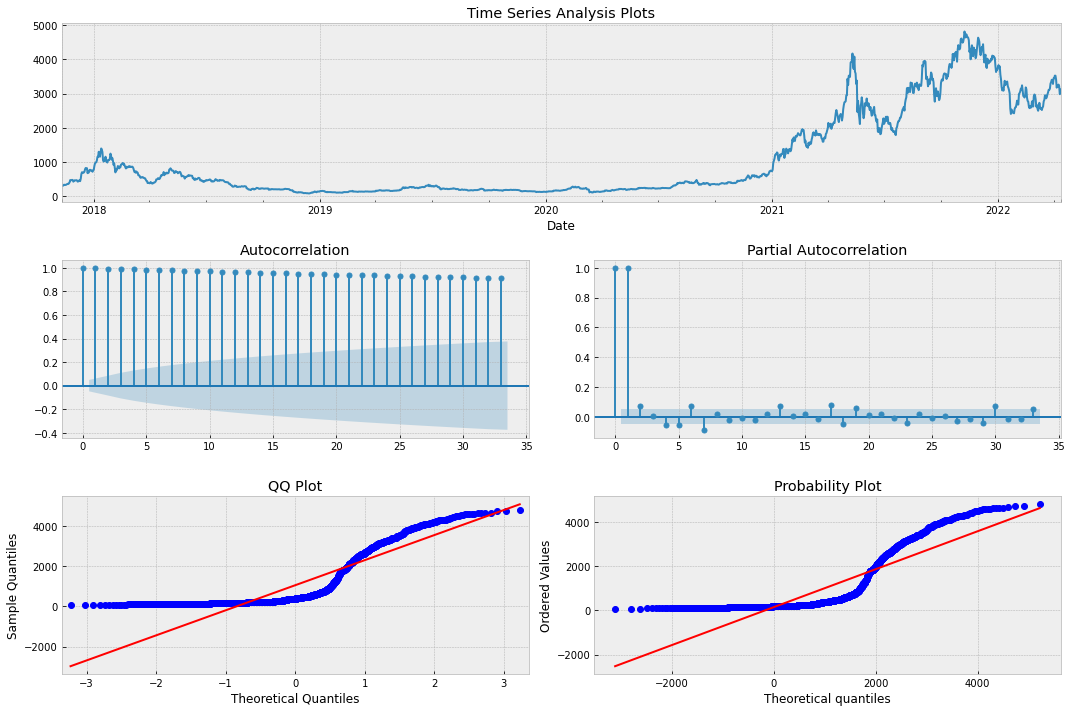

In [51]:
tsplot(data.adjClose)

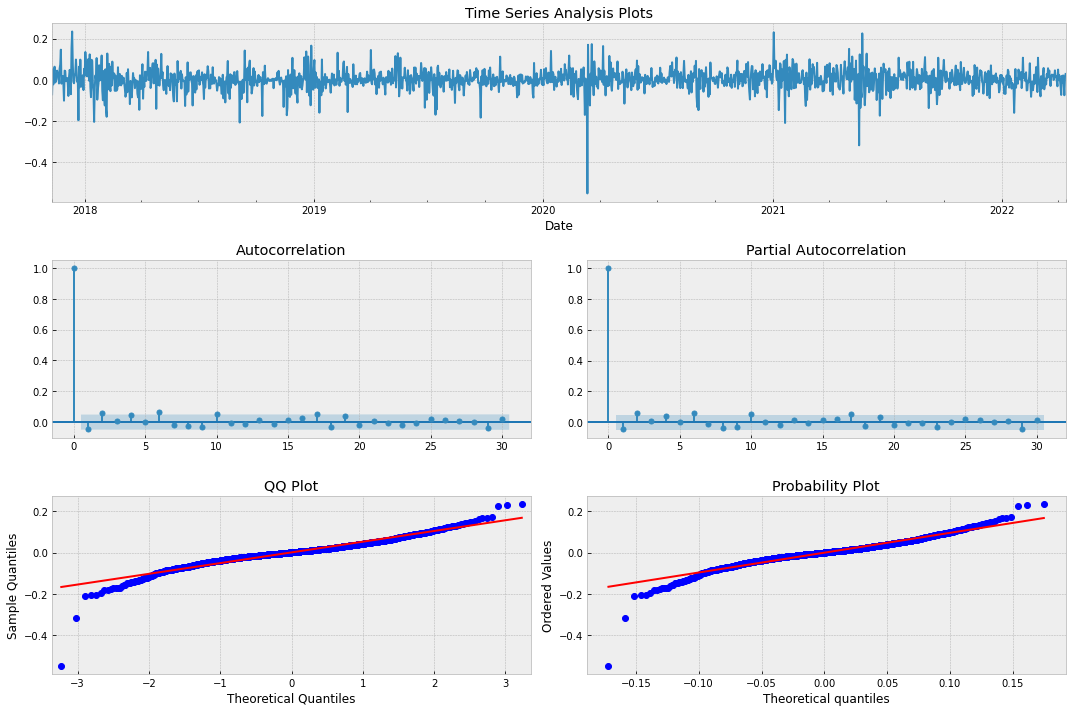

In [52]:
tsplot(data.log_returns, lags=30)

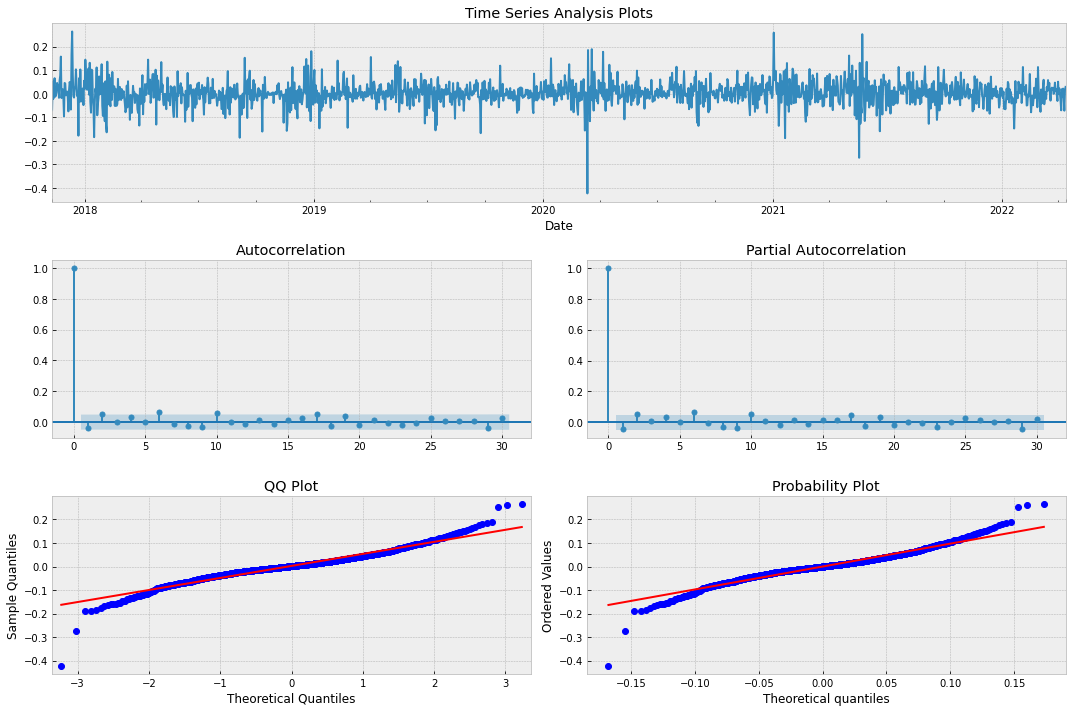

In [53]:
tsplot(data.pct_returns, lags=30)

<Figure size 432x288 with 0 Axes>

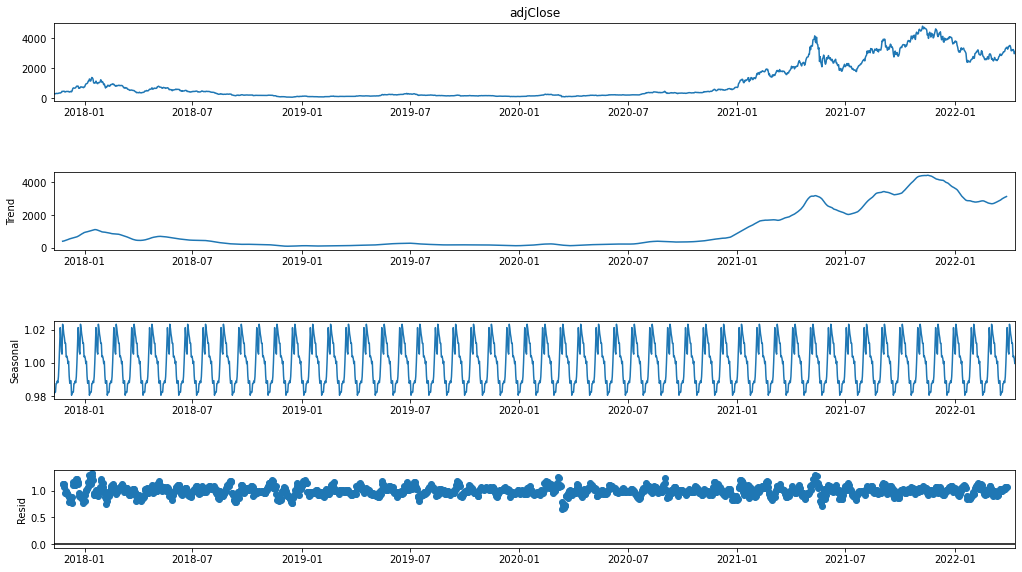

In [55]:
close = seasonal_decompose(data.adjClose, model='multiplicative', freq=30)
fig = plt.figure()
fig = close.plot()
fig.set_size_inches(16,9)

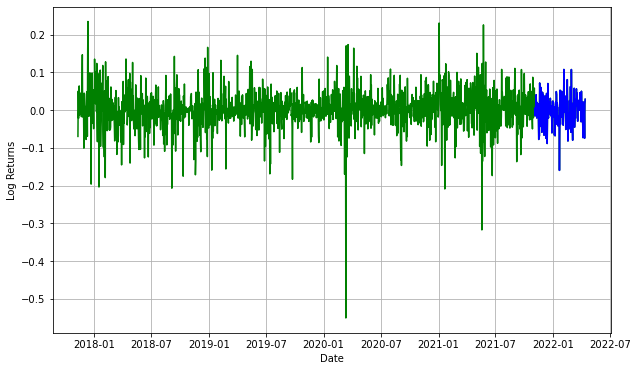

In [56]:
train_data, test_data = (data['log_returns'][3:int(len(data['log_returns'])*0.9)],
                         data['log_returns'][int(len(data['log_returns'])*0.9):])

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.plot(data['log_returns'], color='green', label='Train Data')
plt.plot(test_data, color='blue', label='Test Data')

In [57]:
# Autoregressive Model
# Select the best lag order for the training dataset
max_lag = 30
mdl = smt.AR(train_data).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(train_data).select_order(maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = %s'%(est_order))

best estimated lag order = 10


In [58]:
## Running a test for normality of the residuals
from statsmodels.stats.stattools import jarque_bera

score, p_value, _, _ = jarque_bera(mdl.resid)

print("P-Value is %.3f"%p_value)
if p_value < 0.10:
    print('We have reason to suspect that the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed')

P-Value is 0.000
We have reason to suspect that the residuals are not normally distributed.


In [59]:
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               AR Model Results                               
==============================================================================
Dep. Variable:                      l  -                  o                  g
Model:                         AR(10)   Log Likelihood                2193.237
Method:                          cmle   S.D. of innovations              0.053
Date:                Sat, 10 Aug 2024   AIC                             -5.867
Time:                        17:23:12   BIC                             -5.826
Sample:                    11-13-2017   HQIC                            -5.852
                         - 11-02-2021                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.log_returns     -0.0467      0.026     -1.771      0.077      -0.098       0.005
L2.log_returns      0.0666      0.026      2.521      0.012       0.015       0.118
L3.log_returns      0.0140      0.026      0.530      0.596      -0.038       0.066
L4.log_returns      0.0410      0.026      1.549      0.121      -0.011       0.093
L5.log_returns      0.0115      0.026      0.435      0.664      -0.040       0.063
L6.log_returns      0.0587      0.026      2.220      0.026       0.007       0.111
L7.log_returns     -0.0094      0.026     -0.356      0.722      -0.061       0.042
L8.log_returns     -0.0425      0.026     -1.606      0.108      -0.094       0.009
L9.log_returns     -0.0350      0.026     -1.324      0.185      -0.087       0.017
L10.log_returns     0.0603      0.026      2.282      0.022       0.009       0.112
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.2440           -0.0000j            1.2440           -0.5000
AR.2            -1.0771           -0.7726j            1.3255           -0.4010
AR.3            -1.0771           +0.7726j            1.3255            0.4010
AR.4            -0.4172           -1.2058j            1.2759           -0.3030
AR.5            -0.4172           +1.2058j            1.2759            0.3030
AR.6             0.4647           -1.1832j            1.2712           -0.1904
AR.7             0.4647           +1.1832j            1.2712            0.1904
AR.8             1.2466           -0.7217j            1.4405           -0.0835
AR.9             1.2466           +0.7217j            1.4405            0.0835
AR.10            1.3908           -0.0000j            1.3908           -0.0000
------------------------------------------------------------------------------
"""

In [60]:
# Auto Regressive Moving Average Model
best_aic = np.inf
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(train_data, order=(i,j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i,j)
                best_mdl = tmp_mdl
        except: continue

print('aic: %6.5f | order: %s'%(best_aic, best_order))

aic: -4400.16093 | order: (2, 2)


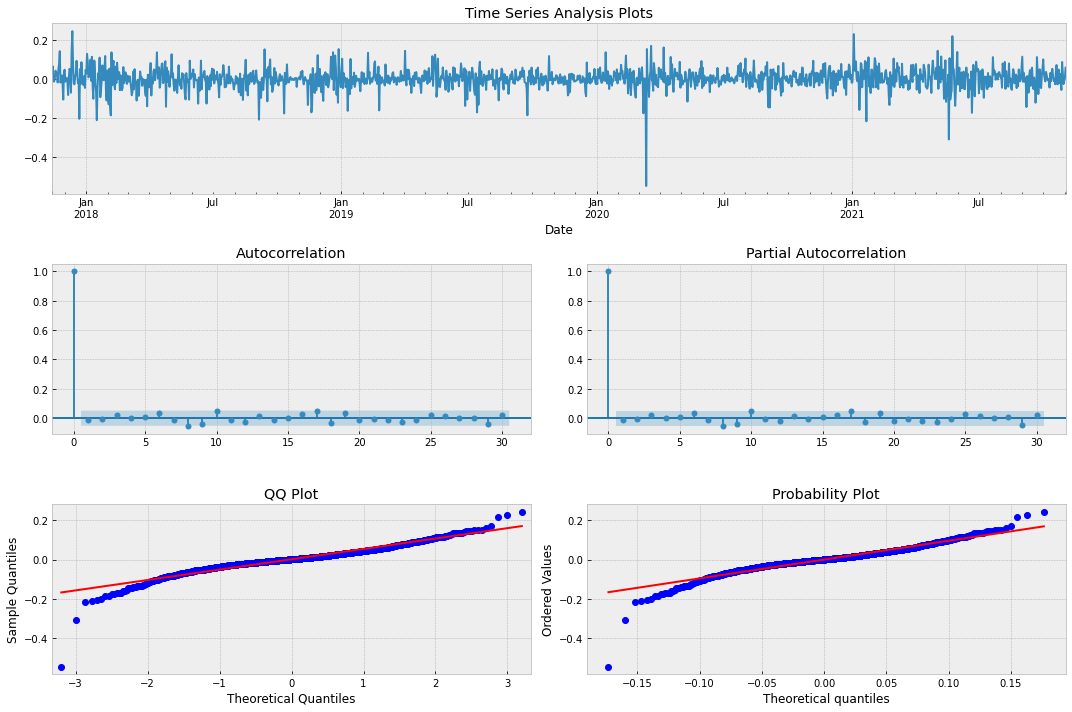

In [61]:
_ = tsplot(best_mdl.resid, lags=max_lag)

In [ ]:
## Fit ARIMA (p,d,q) model to the log returns and close prices
# pick best order and final model based on aic

best_aic = np.inf
best_order = None
best_mdl = None

pq_rng = range(30)
d_rng = range(2)
for i in pq_rng:
    for j in d_rng:
        for k in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(train_data, order=(i,j,k)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i,j,k)
                    best_mdl = tmp_mdl
            except: continue

print('aic %6.5f | order: %s'%(best_aic, best_order))

# ARIMA model residual plot to test if it is normally distributed with mean 0
_ = tsplot(best_mdl.resid, lags=30)
# warnings.filterwarnings('ignore')

In [25]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([22.89659959]), array([0.29390021]))

We perform the Ljung-Box test and find the p-value is significantly larger than 0.05 and as such we can state that there is strong evidence for discrete white noise being a good fit to the residuals. Hence, the ARIMA(2,0,2) model is a good fit, as expected. And our standard test for normality on residuals is below.

In [26]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(best_mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

We have reason to suspect the residuals are not normally distributed.


In [27]:
jarque_bera(best_mdl.resid)

(6647.93542526866, 0.0, -1.0165045753304134, 13.287168379782473)

In [28]:
# Forecasting using the best model
n_steps = 159#len(test_data)

f, err95, ci95 = best_mdl.forecast(n_steps) # 95% Confidence Interval
_, err99, ci99 = best_mdl.forecast(n_steps, alpha=0.01) # 99% Confidence Interval
idx = pd.date_range(train_data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f,ci95]),
                    index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]),
                    index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2021-11-02,8.946812e-06,-0.103746,-0.136348,0.103764,0.136366
2021-11-03,4.671760e-03,-0.099150,-0.131773,0.108493,0.141116
2021-11-04,6.155090e-04,-0.103456,-0.136157,0.104687,0.137388
2021-11-05,3.347614e-03,-0.100737,-0.133443,0.107432,0.140138
2021-11-06,8.670435e-04,-0.103329,-0.136070,0.105063,0.137804
...,...,...,...,...,...
2022-04-05,4.987827e-10,-0.104313,-0.137091,0.104313,0.137091
2022-04-06,4.509167e-10,-0.104313,-0.137091,0.104313,0.137091
2022-04-07,4.076443e-10,-0.104313,-0.137091,0.104313,0.137091
2022-04-08,3.685245e-10,-0.104313,-0.137091,0.104313,0.137091


In [29]:
fc_all.shape

(159, 5)

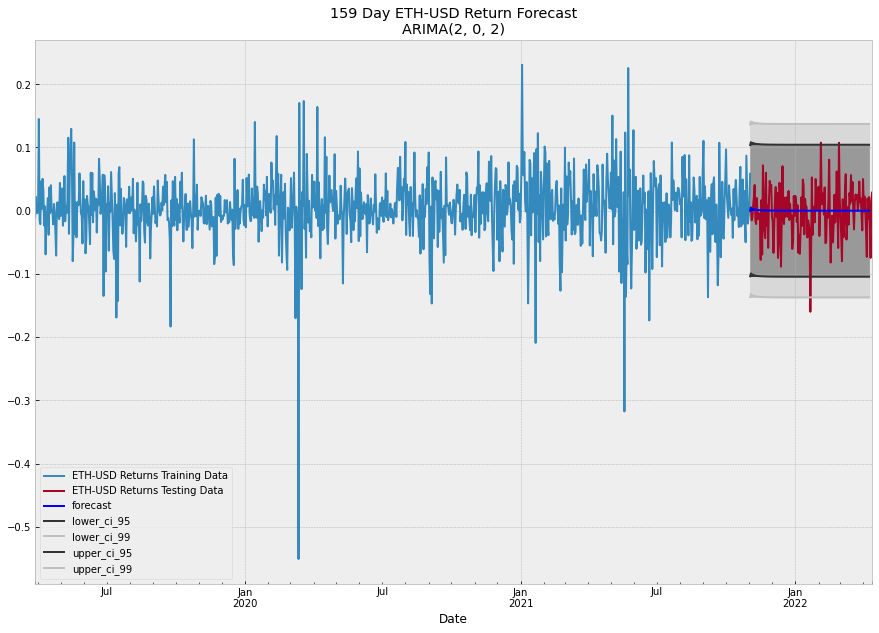

In [30]:
## Plot ETH-USD forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

# ts = data['log_returns'].iloc[500:].copy()
ts = train_data.iloc[500:].copy()
_ = ts.plot(ax=ax, label='ETH-USD Returns Training Data')
ts_2 = test_data.copy()
_ = ts_2.plot(ax=ax, label='ETH-USD Returns Testing Data')

styles = ['b-','0.2','0.75','0.2','0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day ETH-USD Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

In [31]:
df_error = pd.merge(pd.DataFrame(test_data), fc_all, left_index=True, right_index=True, how='left')
df_error.shape
df_error.dropna(inplace=True)

In [32]:
df_error[df_error['forecast'].isnull()].shape

(0, 6)

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math
mse = mean_squared_error(df_error.log_returns, df_error.forecast)
rmse = math.sqrt(mse)
mae = mean_absolute_error(df_error.log_returns, df_error.forecast)
r2 = r2_score(df_error.log_returns, df_error.forecast)

In [34]:
print('Mean Squared Error: %.3f' %mse)
print('Mean Absolute Error: %.3f' %mae)
print('Root Mean Squared Error: %.3f' %rmse)
print('R2 Variance Error: %.3f' %r2)

Mean Squared Error: 0.002
Mean Absolute Error: 0.030
Root Mean Squared Error: 0.039
R2 Variance Error: -0.003


# Implementing a Linear Regression Model

In [40]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math

def linear_regression(x_train, y_train, x_test, y_test):
    regr = linear_model.LinearRegression()
    
    # Train the model using training sets
    regr.fit(x_train, y_train)
    
    # Make predictions based on the model using the testing set
    y_pred = regr.predict(x_test)
    
    # Print the coefficients of the model
    print('Coefficients: \n', regr.coef_)
    
    # Print the Mean Squared Error
    print('Mean Squared Error: %.4f' %mean_squared_error(y_test, y_pred))
    
    # Print the Variance Score
    print('R2 Variance Score: %.4f' %r2_score(y_test, y_pred))
    
    # Plot the outputs
    plt.scatter(y_pred, y_test)
    plt.plot(y_test, y_test, linewidth=3)
    plt.xlabel('Y(actual)')
    plt.ylabel('Y(predicted)')
    plt.show()
    
    return regr, y_pred

In [41]:
train_data.head()

Date
2016-01-05   -0.004519
2016-01-06    0.000720
2016-01-07   -0.009356
2016-01-08    0.046446
2016-01-09    0.000045
Name: log_returns, dtype: float64

In [42]:
# train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
# test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)
pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)

Int64Index([20210401, 20210402, 20210403, 20210404, 20210405, 20210406,
            20210407, 20210408, 20210409, 20210410,
            ...
            20211021, 20211022, 20211023, 20211024, 20211025, 20211026,
            20211027, 20211028, 20211029, 20211030],
           dtype='int64', name='Date', length=213)

Coefficients: 
 [0.]
Mean Squared Error: 0.0034
R2 Variance Score: -0.0000


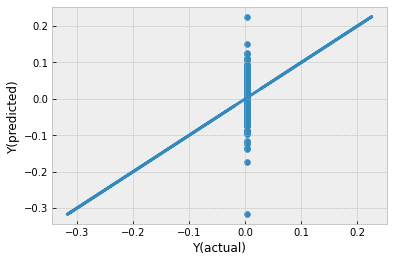

In [46]:
train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)
regr_model, y_pred = linear_regression(x_train=np.array(train_data.index).reshape(-1,1), y_train=train_data,
                                       x_test=np.array(test_data.index).reshape(-1,1), y_test=test_data)

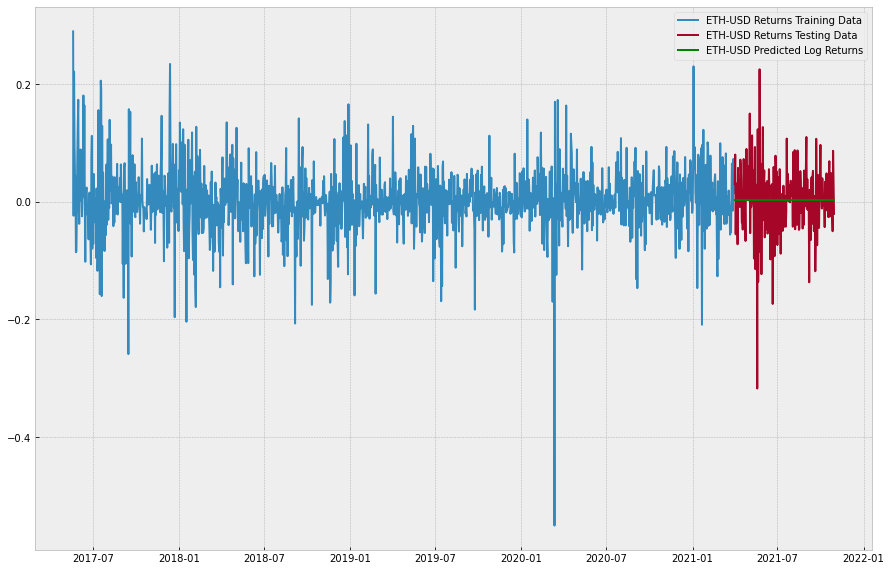

In [58]:
## Plot ETH forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

# ts = data['log_returns'].iloc[500:].copy()
ts = train_data.iloc[500:].copy()
ts.index = pd.to_datetime(ts.index,format='%Y%m%d')
_ = ax.plot(ts, label='ETH-USD Returns Training Data')

ts_2 = test_data.copy()
ts_2.index = pd.to_datetime(ts_2.index,format='%Y%m%d')
_ = ax.plot(ts_2, label='ETH-USD Returns Testing Data')

ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('Date'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()

Coefficients: 
 [[1.66640758e-06 3.31753553e-14]]
Mean Squared Error: 0.0034
R2 Variance Score: -0.0051


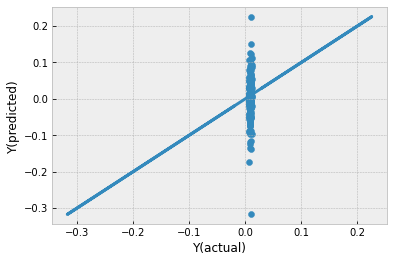

In [59]:
# Linear Regression Model using Volume and the Close Price as features and log returns as the target variable
train_data, test_data = (data[3:int(len(data['log_returns'])*0.9)],
                         data[int(len(data['log_returns'])*0.9):])

train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)

features = ['adjClose','volume']
target = ['log_returns']
regr_model, y_pred = linear_regression(x_train=train_data[features], y_train=train_data[target],
                                      x_test=test_data[features], y_test=test_data[target])

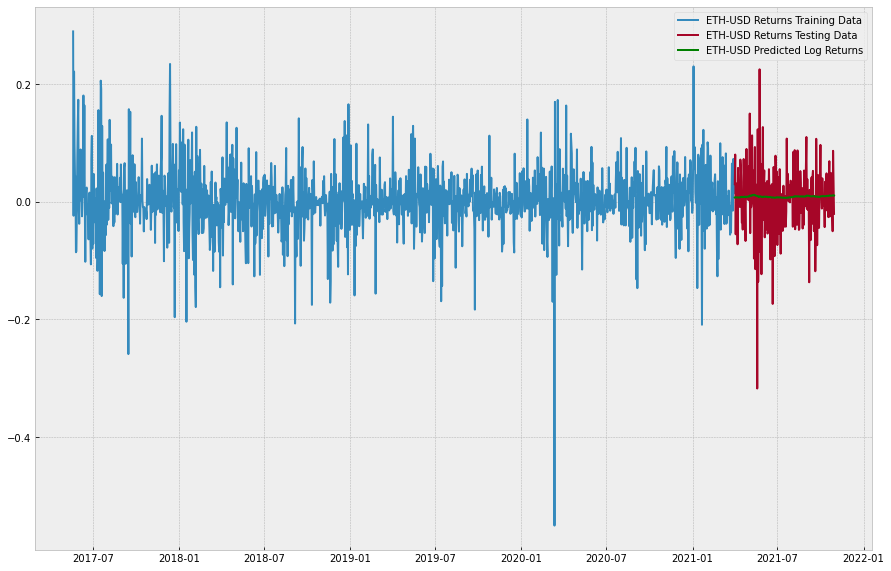

In [60]:
## Plot ETH forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = train_data[target].iloc[500:].copy()
ts.index = pd.to_datetime(ts.index,format='%Y%m%d')
_ = ax.plot(ts, label='ETH-USD Returns Training Data')

ts_2 = test_data[target].copy()
ts_2.index = pd.to_datetime(ts_2.index,format='%Y%m%d')
_ = ax.plot(ts_2, label='ETH-USD Returns Testing Data')

ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('Date'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()

In [61]:
# Building features for momentum
def difference(df, period):
    return df.sub(df.shift(period), fill_value=0)

In [62]:
data = data.assign(mom10 = difference(data.log_returns, 11))
data = data.assign(mom50 = difference(data.log_returns, 51))
data = data.assign(mom100 = difference(data.log_returns, 101))
train_data, test_data = (data[3:int(len(data['log_returns'])*0.9)],
                         data[int(len(data['log_returns'])*0.9):])

Coefficients: 
 [[4.18474494e-07 5.65390658e-14 3.21302613e-01 3.41739302e-01]]
Mean Squared Error: 0.0012
R2 Variance Score: 0.6391


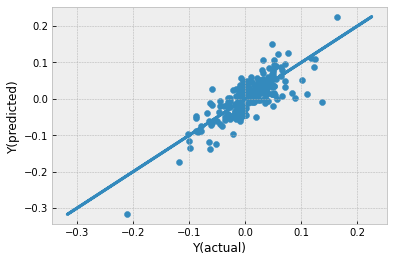

In [63]:
# Linear Regression Model using Open Price, Volume, 50 day momentum and 100 day momentum
# as features and log returns as the target variable
train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)

features = ['open','volume', 'mom50', 'mom100']
target = ['log_returns']
regr_model, y_pred = linear_regression(x_train=train_data[features], y_train=train_data[target],
                                      x_test=test_data[features], y_test=test_data[target])

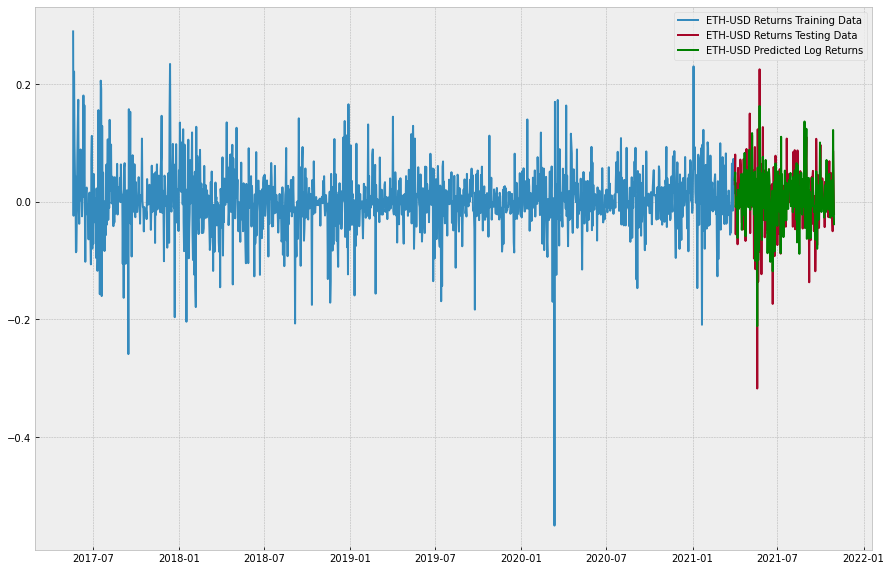

In [64]:
## Plot ETH-USD forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = train_data[target].iloc[500:].copy()
ts.index = pd.to_datetime(ts.index,format='%Y%m%d')
_ = ax.plot(ts, label='ETH-USD Returns Training Data')

ts_2 = test_data[target].copy()
ts_2.index = pd.to_datetime(ts_2.index,format='%Y%m%d')
_ = ax.plot(ts_2, label='ETH-USD Returns Testing Data')

ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('Date'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()

Coefficients: 
 [[5.55129790e-07 8.74867800e-14 2.41742722e-01 2.49518016e-01
  2.60403271e-01]]
Mean Squared Error: 0.0009
R2 Variance Score: 0.7464


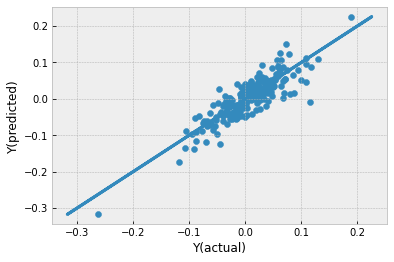

In [65]:
# Linear Regression Model using Open Price, Volume, 10 day momentum, 50 day momentum and 100 day momentum
# as features and log returns as the target variable
train_data, test_data = (data[3:int(len(data['log_returns'])*0.9)],
                         data[int(len(data['log_returns'])*0.9):])

train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)

features = ['open','volume', 'mom10', 'mom50', 'mom100']
target = ['log_returns']
regr_model, y_pred = linear_regression(x_train=train_data[features], y_train=train_data[target],
                                      x_test=test_data[features], y_test=test_data[target])

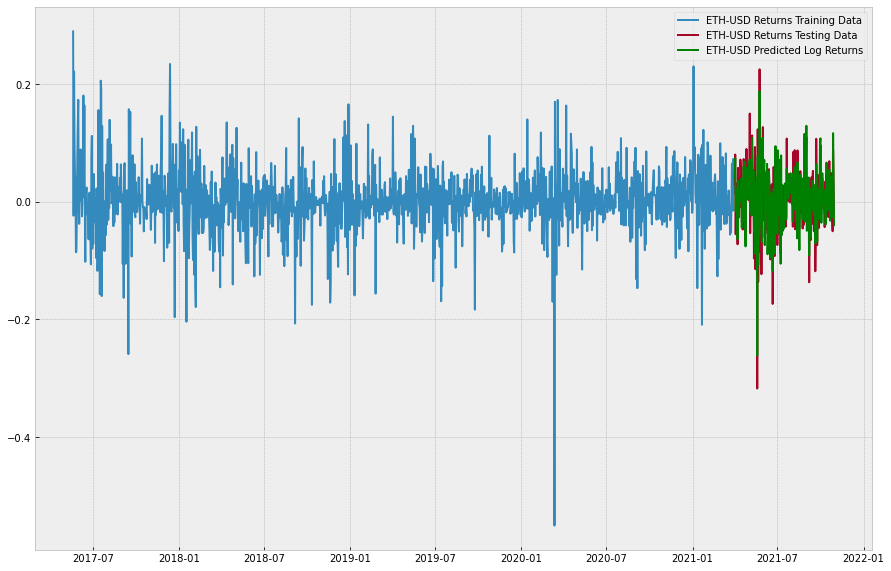

In [67]:
## Plot ETH-USD forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = train_data[target].iloc[500:].copy()
ts.index = pd.to_datetime(ts.index,format='%Y%m%d')
_ = ax.plot(ts, label='ETH-USD Returns Training Data')

ts_2 = test_data[target].copy()
ts_2.index = pd.to_datetime(ts_2.index,format='%Y%m%d')
_ = ax.plot(ts_2, label='ETH-USD Returns Testing Data')

ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('Date'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()

Coefficients: 
 [[0.24150761 0.24929498 0.26065757]]
Mean Squared Error: 0.0009
R2 Variance Score: 0.7498


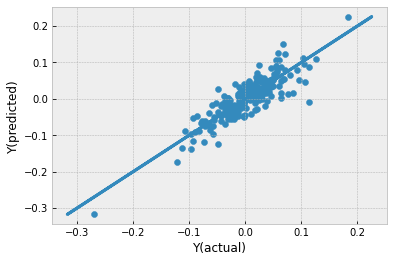

In [68]:
# Linear Regression Model using Open Price, Volume, 10 day momentum, 50 day momentum and 100 day momentum
# as features and log returns as the target variable
train_data, test_data = (data[3:int(len(data['log_returns'])*0.9)],
                         data[int(len(data['log_returns'])*0.9):])

train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)

features = ['mom10', 'mom50', 'mom100']
target = ['log_returns']
regr_model, y_pred = linear_regression(x_train=train_data[features], y_train=train_data[target],
                                       x_test=test_data[features], y_test=test_data[target])

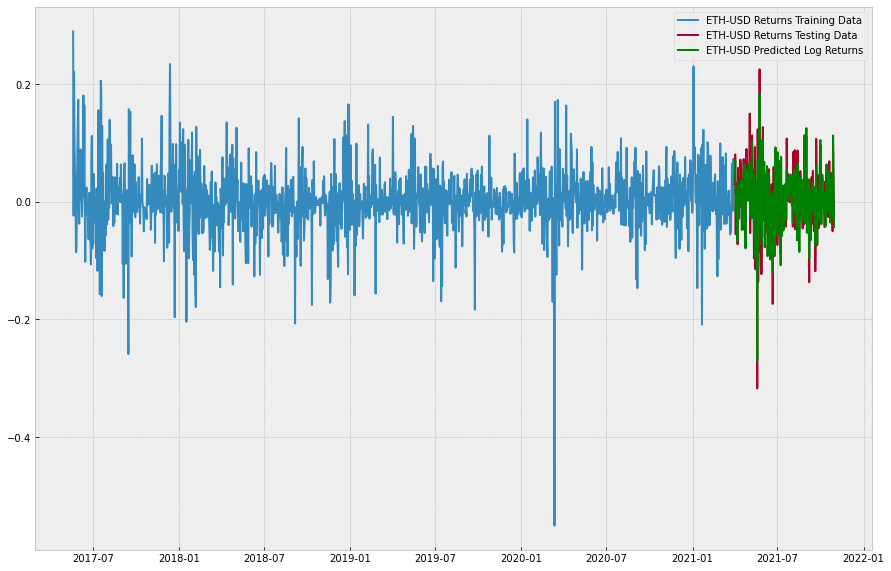

In [70]:
## Plot ETH-USD forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = train_data[target].iloc[500:].copy()
ts.index = pd.to_datetime(ts.index,format='%Y%m%d')
_ = ax.plot(ts, label='ETH-USD Returns Training Data')

ts_2 = test_data[target].copy()
ts_2.index = pd.to_datetime(ts_2.index,format='%Y%m%d')
_ = ax.plot(ts_2, label='ETH-USD Returns Testing Data')

ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('Date'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()

In [71]:
ypred.tail()

,open,high,low,close,adjClose,volume,log_returns,mom10,mom50,mom100,pred_log_returns
Date,,,,,,,,,,,
2021-10-26,4217.337891,4289.131348,4106.823730,4131.102051,4131.102051,17157714562,-0.020788,-0.040823,-0.037193,-0.030548,-0.023276
2021-10-27,4132.173340,4299.152832,3930.257324,3930.257324,3930.257324,26219530404,-0.049839,-0.041454,-0.043811,-0.048114,-0.029657
2021-10-28,3924.815430,4293.150879,3905.706055,4287.318848,4287.318848,25958154575,0.086957,0.082600,0.223675,0.129117,0.113182
2021-10-29,4288.686523,4455.735352,4271.707520,4414.746582,4414.746582,22967641914,0.029289,0.055184,0.008802,0.045815,0.031281
2021-10-30,4414.243652,4426.848633,4252.494141,4325.650391,4325.650391,14615490626,-0.020388,-0.054192,-0.000177,-0.128186,-0.042727


In [74]:
ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('index'))
ypred.head()

,open,high,low,close,adjClose,volume,log_returns,mom10,mom50,mom100,pred_log_returns
index,,,,,,,,,,,
20210401,1919.157227,1989.055054,1912.178467,1977.276855,1977.276855,30914259795,0.030249,0.043811,0.018061,0.075883,0.038680
20210402,1976.932739,2152.451904,1960.678711,2143.225586,2143.225586,34862511022,0.080591,0.136293,0.094139,0.040356,0.070721
20210403,2142.895996,2144.962402,2028.422485,2028.422485,2028.422485,32011518871,-0.055054,-0.047526,-0.077477,0.028930,-0.019435
20210404,2027.671265,2110.353516,2007.111816,2093.122803,2093.122803,26006501902,0.031399,0.083510,-0.001540,-0.015279,0.019619
20210405,2093.260742,2140.985352,2032.387695,2107.887207,2107.887207,28889391170,0.007029,0.005809,0.023118,-0.016887,0.006581


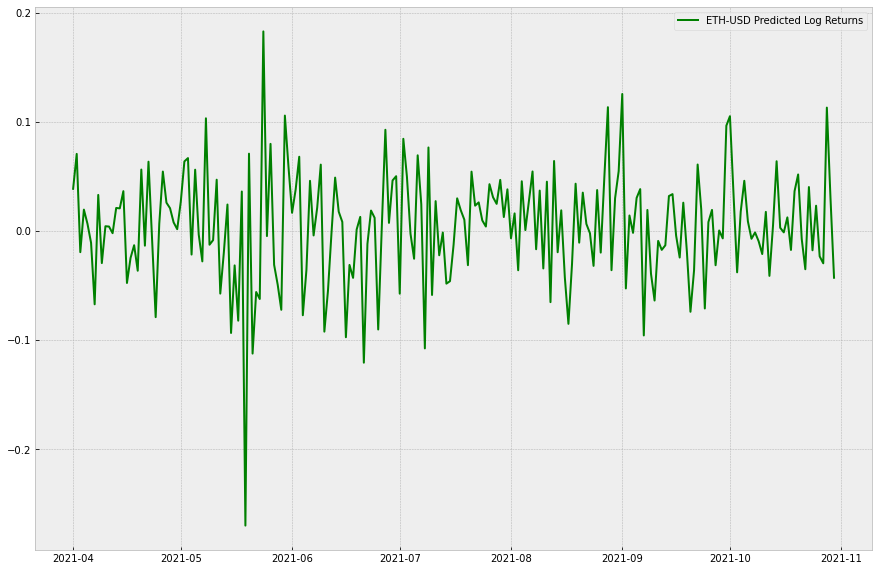

In [75]:
plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('index'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()

In [88]:
data.shift(1).head()

,open,high,low,close,adjClose,volume,log_returns,mom10,mom50,mom100
Date,,,,,,,,,,
2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,0.947401,0.969637,0.936560,0.937124,0.937124,255504.0,-0.011564,-0.011564,-0.011564,-0.011564
2016-01-04,0.938430,0.991362,0.934313,0.971905,0.971905,407632.0,0.036442,0.036442,0.036442,0.036442
2016-01-05,0.972045,0.976438,0.929835,0.954480,0.954480,346245.0,-0.018091,-0.018091,-0.018091,-0.018091
2016-01-06,0.953147,0.970597,0.946543,0.950176,0.950176,219833.0,-0.004519,-0.004519,-0.004519,-0.004519


In [87]:
data.close.pct_change()head()

,open,high,low,close,adjClose,volume,log_returns,mom10,mom50,mom100
Date,,,,,,,,,,
2016-01-02,0.947401,0.969637,0.936560,0.937124,0.937124,255504,-0.011564,-0.011564,-0.011564,-0.011564
2016-01-03,0.938430,0.991362,0.934313,0.971905,0.971905,407632,0.036442,0.036442,0.036442,0.036442
2016-01-04,0.972045,0.976438,0.929835,0.954480,0.954480,346245,-0.018091,-0.018091,-0.018091,-0.018091
2016-01-05,0.953147,0.970597,0.946543,0.950176,0.950176,219833,-0.004519,-0.004519,-0.004519,-0.004519
2016-01-06,0.950028,0.960659,0.935708,0.950860,0.950860,308791,0.000720,0.000720,0.000720,0.000720


In [85]:
# data = data.assign(log_returns = np.log(data.close/data.close.shift(1))).dropna()
ypred = ypred.assign(pred_returns = np.exp(ypred.pred_log_returns))
ypred = ypred.assign(pred_prices = np.cumprod(ypred.pred_returns) + ypred.adjClose.iloc[0])

In [82]:
train_data.tail()

,open,high,low,close,adjClose,volume,log_returns,mom10,mom50,mom100
20210327,1703.036133,1732.824341,1674.319336,1716.494629,1716.494629,18102277710,0.007986,-0.000501,0.048626,-0.068469
20210328,1716.405640,1728.584106,1672.660400,1691.355957,1691.355957,16599472938,-0.014754,-0.023831,-0.089568,-0.025210
20210329,1691.263184,1837.187988,1683.716553,1819.684937,1819.684937,22796570548,0.073133,0.095647,0.097161,0.054726
20210330,1819.466309,1860.974731,1793.922363,1846.033691,1846.033691,22512781703,0.014376,-0.004938,0.053031,0.007549
20210331,1846.098267,1947.837769,1793.002197,1918.362061,1918.362061,30226902621,0.038432,0.041181,-0.040392,0.070814


In [77]:
ypred.head()

,open,high,low,close,adjClose,volume,log_returns,mom10,mom50,mom100,pred_log_returns,pred_returns,pred_prices
index,,,,,,,,,,,,,
2021-04-01,1919.157227,1989.055054,1912.178467,1977.276855,1977.276855,30914259795,0.030249,0.043811,0.018061,0.075883,0.038680,1.039438,1978.316293
2021-04-02,1976.932739,2152.451904,1960.678711,2143.225586,2143.225586,34862511022,0.080591,0.136293,0.094139,0.040356,0.070721,1.073281,1979.389574
2021-04-03,2142.895996,2144.962402,2028.422485,2028.422485,2028.422485,32011518871,-0.055054,-0.047526,-0.077477,0.028930,-0.019435,0.980753,1980.370327
2021-04-04,2027.671265,2110.353516,2007.111816,2093.122803,2093.122803,26006501902,0.031399,0.083510,-0.001540,-0.015279,0.019619,1.019813,1981.390140
2021-04-05,2093.260742,2140.985352,2032.387695,2107.887207,2107.887207,28889391170,0.007029,0.005809,0.023118,-0.016887,0.006581,1.006603,1982.396743


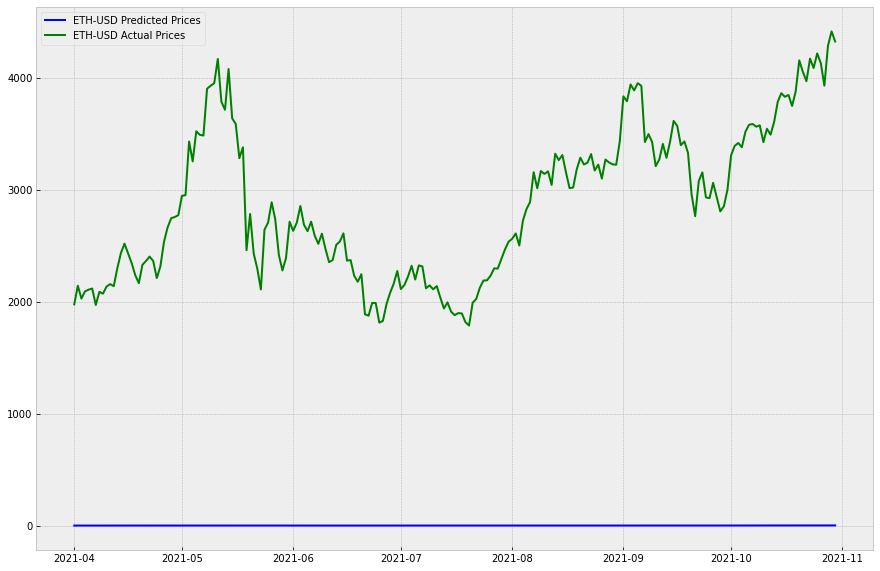

In [86]:
plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
# _ = ax.plot(ypred['pred_returns'], label='ETH-USD Predicted Absolute Returns',color='green')
_ = ax.plot(ypred['pred_prices'], label='ETH-USD Predicted Prices',color='blue')
_ = ax.plot(ypred['adjClose'], label='ETH-USD Actual Prices',color='green')
_ = ax.legend()

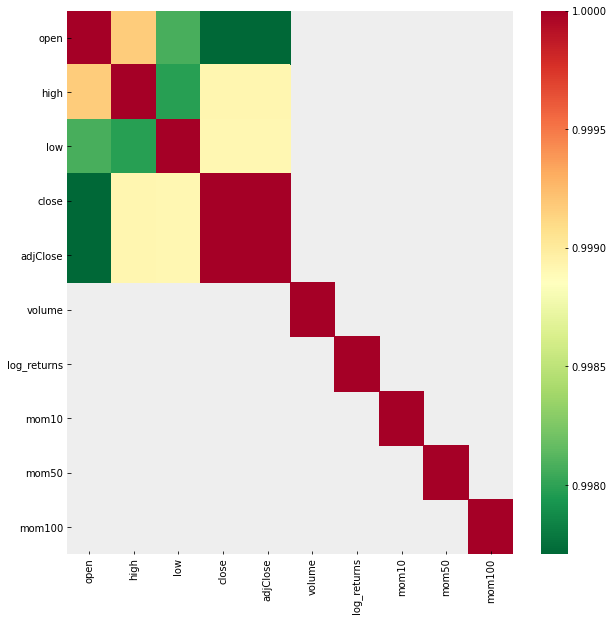

In [67]:
import seaborn

c = data.corr()
plt.figure(figsize=(10,10))
_ = seaborn.heatmap(c, cmap='RdYlGn_r', mask=(np.abs(c) <= 0.8))

In [49]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math

def lasso_regression(x_train, y_train, x_test, y_test, alpha=0.3):
    regr = linear_model.Lasso(alpha)
    
    # Train the model using training sets
    regr.fit(x_train, y_train)
    
    # Make predictions based on the model using the testing set
    y_pred = regr.predict(x_test)
    
    # Print the coefficients of the model
    print('Coefficients: \n', regr.coef_)
    
    # Print the Mean Squared Error
    print('Mean Squared Error: %.4f' %mean_squared_error(y_test, y_pred))
    
    # Print the Variance Score
    print('R2 Variance Score: %.4f' %r2_score(y_test, y_pred))
    
    # Plot the outputs
    plt.scatter(y_pred, y_test)
    plt.plot(y_test, y_test, linewidth=3)
    plt.xlabel('Y(actual)')
    plt.ylabel('Y(predicted)')
    plt.show()
    
    return regr, y_pred

Coefficients: 
 [-6.33145260e-06  2.38869063e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
Mean Squared Error: 0.0035
R2 Variance Score: -0.0396


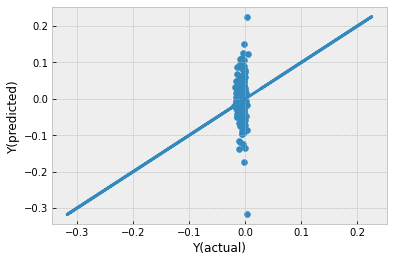

In [50]:
# Lasso Regression Model using Open Price, Volume, 10 day momentum, 50 day momentum and 100 day momentum
# as features and log returns as the target variable
train_data, test_data = (data[3:int(len(data['log_returns'])*0.9)],
                         data[int(len(data['log_returns'])*0.9):])

train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)

features = ['open','volume', 'mom10', 'mom50', 'mom100']
target = ['log_returns']
regr_model, y_pred = lasso_regression(x_train=train_data[features], y_train=train_data[target],
                                      x_test=test_data[features], y_test=test_data[target])

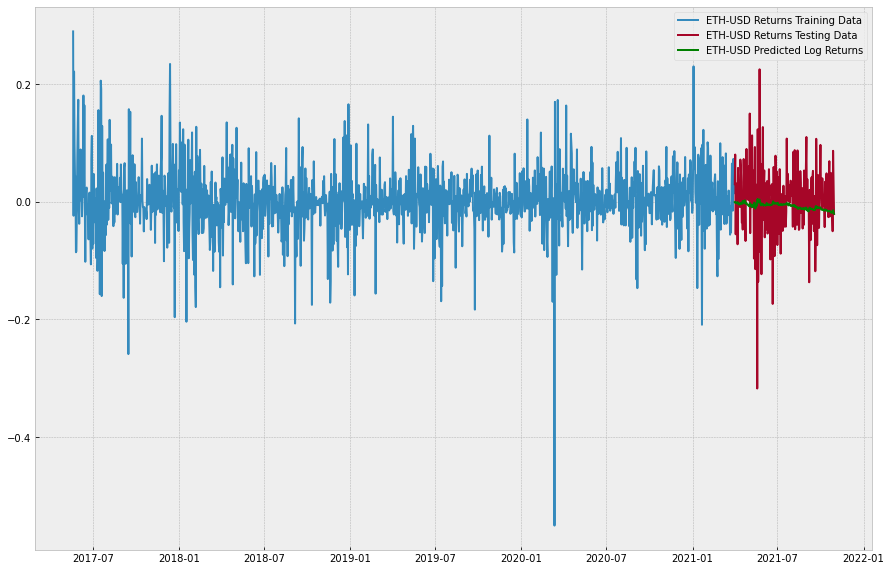

In [51]:
## Plot ETH-USD forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = train_data[target].iloc[500:].copy()
ts.index = pd.to_datetime(ts.index,format='%Y%m%d')
_ = ax.plot(ts, label='ETH-USD Returns Training Data')

ts_2 = test_data[target].copy()
ts_2.index = pd.to_datetime(ts_2.index,format='%Y%m%d')
_ = ax.plot(ts_2, label='ETH-USD Returns Testing Data')

ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('index'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()

In [52]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math

def ridge_regression(x_train, y_train, x_test, y_test, alpha=10000):
    regr = linear_model.Ridge(alpha)
    
    # Train the model using training sets
    regr.fit(x_train, y_train)
    
    # Make predictions based on the model using the testing set
    y_pred = regr.predict(x_test)
    
    # Print the coefficients of the model
    print('Coefficients: \n', regr.coef_)
    
    # Print the Mean Squared Error
    print('Mean Squared Error: %.4f' %mean_squared_error(y_test, y_pred))
    
    # Print the Variance Score
    print('R2 Variance Score: %.4f' %r2_score(y_test, y_pred))
    
    # Plot the outputs
    plt.scatter(y_pred, y_test)
    plt.plot(y_test, y_test, linewidth=3)
    plt.xlabel('Y(actual)')
    plt.ylabel('Y(predicted)')
    plt.show()
    
    return regr, y_pred

Coefficients: 
 [[-9.96491375e-06  3.32220464e-13  6.42247326e-04  6.74498606e-04
   6.87422778e-04]]
Mean Squared Error: 0.0038
R2 Variance Score: -0.1041


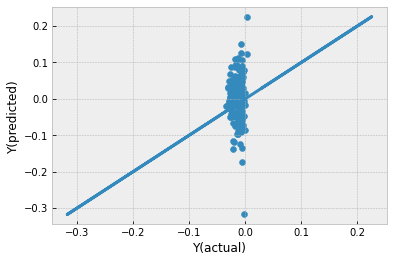

In [53]:
# Ridge Regression Model using Open Price, Volume, 10 day momentum, 50 day momentum and 100 day momentum
# as features and log returns as the target variable
train_data, test_data = (data[3:int(len(data['log_returns'])*0.9)],
                         data[int(len(data['log_returns'])*0.9):])

train_data.index = pd.to_datetime(train_data.index).strftime('%Y%m%d').astype(int)
test_data.index = pd.to_datetime(test_data.index).strftime('%Y%m%d').astype(int)

features = ['open','volume', 'mom10', 'mom50', 'mom100']
target = ['log_returns']
regr_model, y_pred = ridge_regression(x_train=train_data[features], y_train=train_data[target],
                                      x_test=test_data[features], y_test=test_data[target])

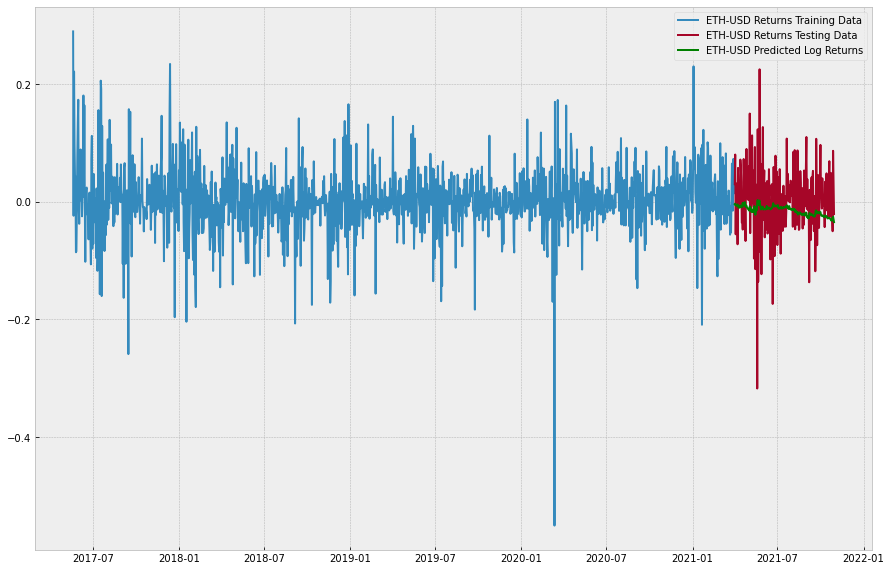

In [57]:
## Plot ETH-USD forecast

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = train_data[target].iloc[500:].copy()
ts.index = pd.to_datetime(ts.index,format='%Y%m%d')
_ = ax.plot(ts, label='ETH-USD Returns Training Data')

ts_2 = test_data[target].copy()
ts_2.index = pd.to_datetime(ts_2.index,format='%Y%m%d')
_ = ax.plot(ts_2, label='ETH-USD Returns Testing Data')

ypred = (pd.concat([pd.DataFrame(test_data).reset_index(), pd.DataFrame(y_pred)], axis=1)
          .rename(columns={0:'pred_log_returns'})
          .set_index('index'))
ypred.index = pd.to_datetime(ypred.index, format='%Y%m%d')
_ = ax.plot(ypred['pred_log_returns'], label='ETH-USD Predicted Log Returns',color='green')
_ = ax.legend()